Realizando o trabalho do artigo "PREVISÕES HIDROCLIMÁTICAS PARA A BACIA DO RIO NEGRO UTILIZANDO APRENDIZADO DE MÁQUINA", dos autores Alejandro da Rocha Loureiro, Ian Mateus Ribeiro de Souza, Milton Honório Pinheiro Neto, Francis Wagner Silva Correia, Mario Augusto Bessa de Figueiredo, Weslley de Brito Gomes, Leonardo Alves Vergasta

DOI: 10.51859/AMPLLA.3ASAC17-4\
Fonte: https://ampllaeditora.com.br/books/2024/05/ASAC2023.pdf

In [ ]:
# Bibliotecas
from modulos import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

## Estações

Os dados foram obtidos da Agência Nacional de Águas e Saneamento Básico (ANA) em https://www.snirh.gov.br/hidroweb/serieshistoricas

1. 14300000\
Nome Estação : PARI CACHOEIRA \
Bacia : 1 - RIO AMAZONAS \
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,.... \
Rio : RIO TIQUIÉ \
Estado : AMAZONAS \
Município : SÃO GABRIEL DA CACHOEIRA \
Latitude : 0.2494 \
Longitude : -69.785


2. 14550000\
Nome Estação : MALOCA DO CONTÃO \
Bacia : 1 - RIO AMAZONAS \
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,....\
Rio : RIO COTINGO\
Estado : RORAIMA\
Município : PACARAIMA\
Latitude : 4.1675\
Longitude : -60.5289

3. 14845000\
Nome Estação : FAZENDA SÃO JOSÉ \
Bacia : 1 - RIO AMAZONAS\
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,....\
Rio : RIO JAUAPERI\
Estado : RORAIMA\
Município : RORAINÓPOLIS\
Latitude : 0.5178\
Longitude : -60.4661

4. 14990000\
Nome Estação : MANAUA\
Bacia : 1 - RIO AMAZONAS\
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,...\
Rio : RIO NEGRO\
Estado : AMAZONAS\
Município : MANAUS\
Latitude : -3.1383\
Longitude : -60.0272

## Visualizando os dados 

In [2]:
# Abrindo o arquivo CSV
path = 'Datasets processados'
arquivos = [
    'dados_diarios_estacao_14300000.csv',
    'dados_diarios_estacao_14550000.csv',
    'dados_diarios_estacao_14845000.csv',
    'dados_diarios_estacao_14990000.csv'
]

dados = eda.data_processing(path, '1985-01-01', '2023-12-31', arquivos)
dados

,14300000,14550000,14845000,14990000
Data,,,,
1985-01-01,842.0,196.0,253.0,2169.0
1985-01-02,822.0,165.0,252.0,2178.0
1985-01-03,798.0,202.0,252.0,2186.0
1985-01-04,751.0,157.0,249.0,2194.0
1985-01-05,709.0,197.0,245.0,2201.0
...,...,...,...,...
2023-12-27,553.0,144.0,345.0,1807.0
2023-12-28,543.0,142.0,345.0,1822.0
2023-12-29,678.0,140.0,345.0,1834.0


In [3]:
# Separando os dados em treino e teste
# Treino: até 31 de dezembro de 2014
# Teste: de 1º de janeiro de 2015 e diante
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

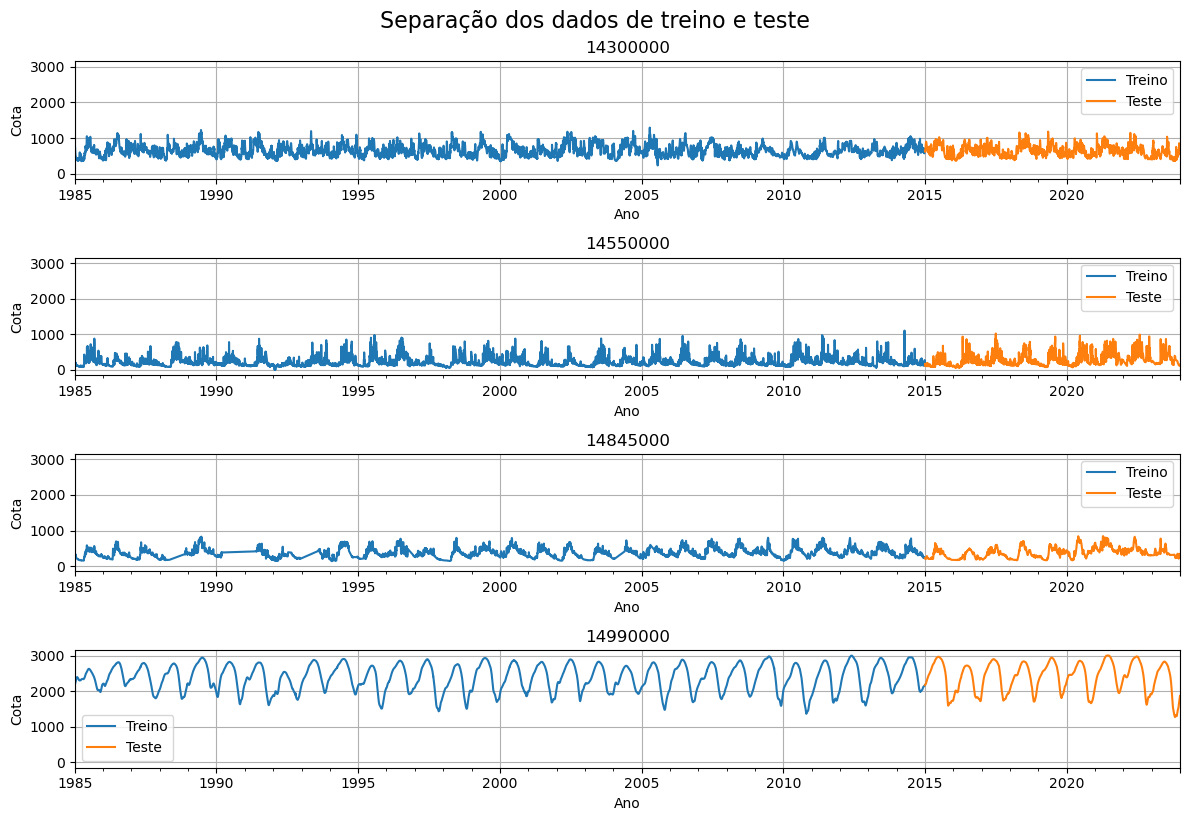

In [4]:
# Plotando os dados de treino e teste

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharey=True)
fig.subplots_adjust(hspace=1)
ax = ax.ravel()

for i, col in enumerate(dados):
    treino[col].plot(ax=ax[i], label='Treino')
    teste[col].plot(ax=ax[i], label='Teste')
    ax[i].set_title(col)
    ax[i].set_ylabel('Cota')
    ax[i].set_xlabel('Ano')
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.suptitle('Separação dos dados de treino e teste', fontsize=16, y=1.02)
plt.show()

### Funções

In [5]:
# Função para treinar o modelo

def treinar_modelo(modelo, treino, teste):
    # Criação de batches
    window_length = 365
    shifts = np.arange(1,window_length+1)
    # Create a dictionary of time-shifted data
    x_shifts = {'lag_{}'.format(ii): treino.shift(ii) for ii in shifts}
    # Convert the shifts into a dataframe
    x_shifts = pd.DataFrame(x_shifts)
    x_shifts.fillna(0, inplace=True)

    # Loop de Treinamento
    modelo.fit(x_shifts, treino)

    test_predictions = []
    first_eval_batch = treino[-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = modelo.predict(current_batch)[0]
        # store prediction
        test_predictions.append(current_pred)
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)
    return test_predictions

In [6]:
# Função para plotar os resultados

def plot_resultado(resultado, teste):
    y_pred = pd.DataFrame(resultado)
    y_pred.index = teste.index

    r2 = r2_score(teste, y_pred)
    mse = mean_squared_error(teste, y_pred)
    rmse = root_mean_squared_error(teste, y_pred)
    mae = mean_absolute_error(teste, y_pred)

    print(f'R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    plt.figure(figsize=(16, 2))
    plt.plot(teste, label='Teste')
    plt.plot(y_pred, label='Predição')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.title(f'Predição de Cotas - Estação {teste.name}')
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

### MLP

In [7]:
mlp = MLPRegressor(hidden_layer_sizes=(11, 11), max_iter=1000, learning_rate_init=0.004)

R²: -0.1764, MSE: 30161.3418, RMSE: 173.6702, MAE: 136.3506


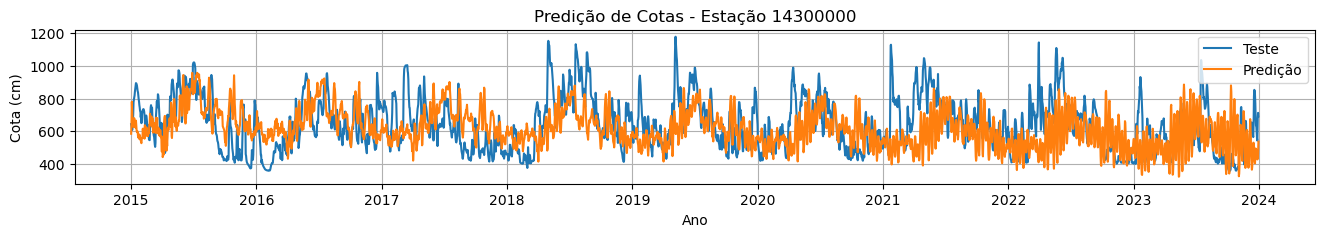

R²: -0.0297, MSE: 25686.7678, RMSE: 160.2709, MAE: 105.6614


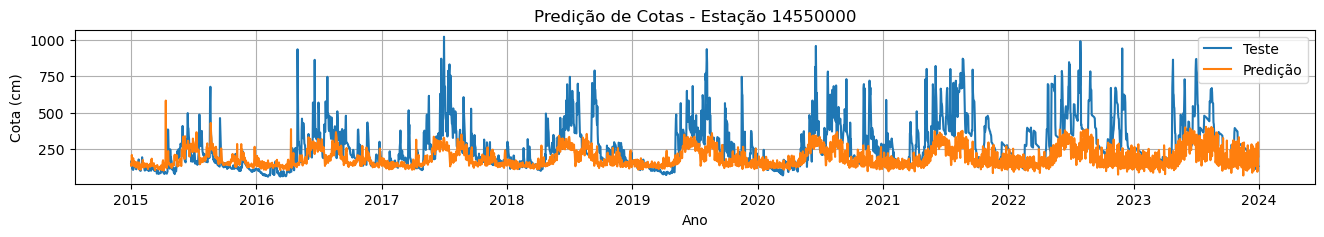

R²: 0.3504, MSE: 13899.3305, RMSE: 117.8954, MAE: 93.4013


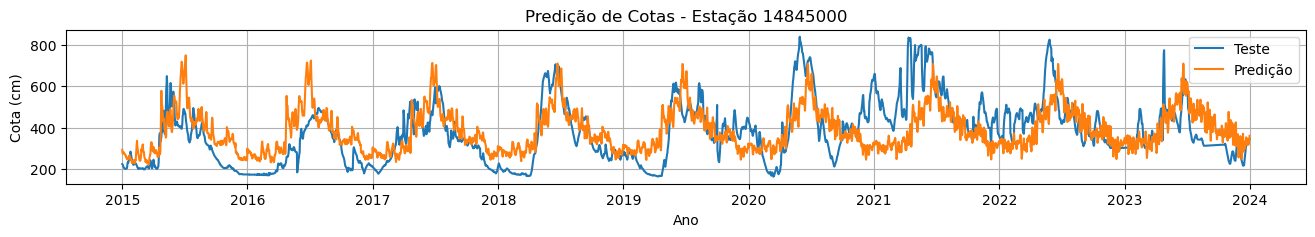

R²: 0.3734, MSE: 111077.7388, RMSE: 333.2833, MAE: 270.8209


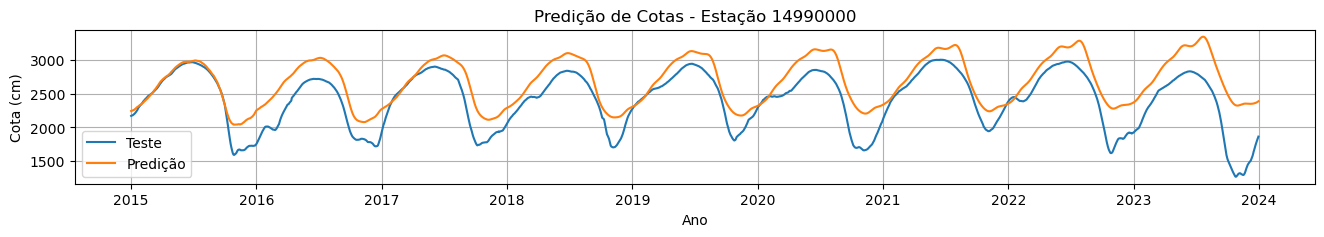

In [8]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(mlp, treino[col], teste[col])
    plot_resultado(resultado, teste[col])

### Random Forest

In [9]:
rf = RandomForestRegressor(n_jobs=-1)

R²: -0.3331, MSE: 34179.7476, RMSE: 184.8777, MAE: 150.6022


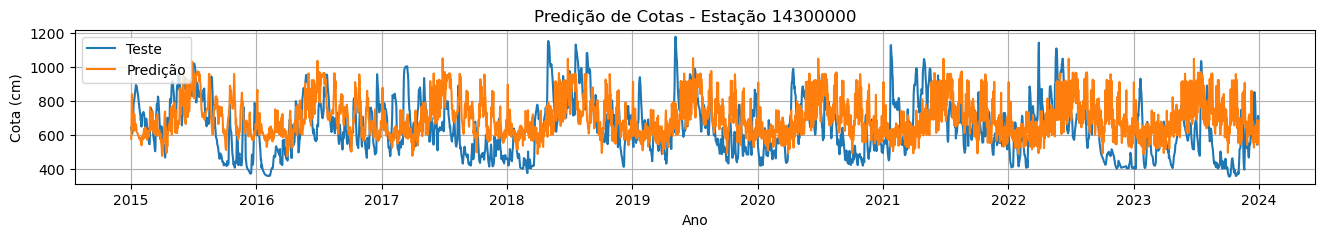

R²: -0.3402, MSE: 33433.9900, RMSE: 182.8496, MAE: 123.1773


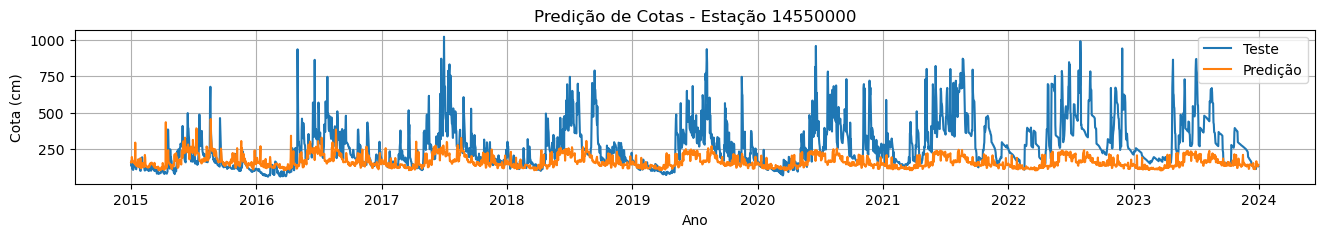

R²: 0.2333, MSE: 16403.9626, RMSE: 128.0780, MAE: 98.9368


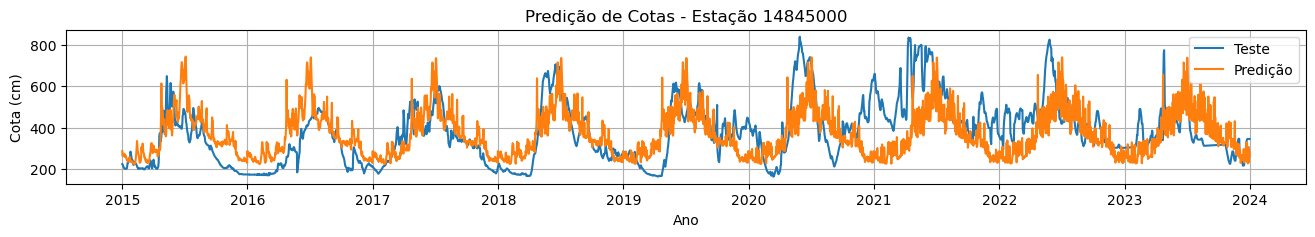

R²: 0.7163, MSE: 50295.0891, RMSE: 224.2657, MAE: 164.4055


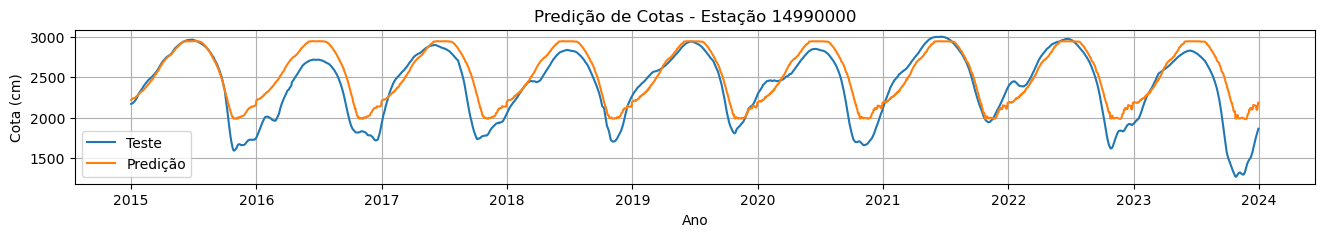

In [10]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(rf, treino[col], teste[col])
    plot_resultado(resultado, teste[col])

### SVR

In [11]:
svr = SVR()

R²: -0.0488, MSE: 26891.0911, RMSE: 163.9850, MAE: 129.9685


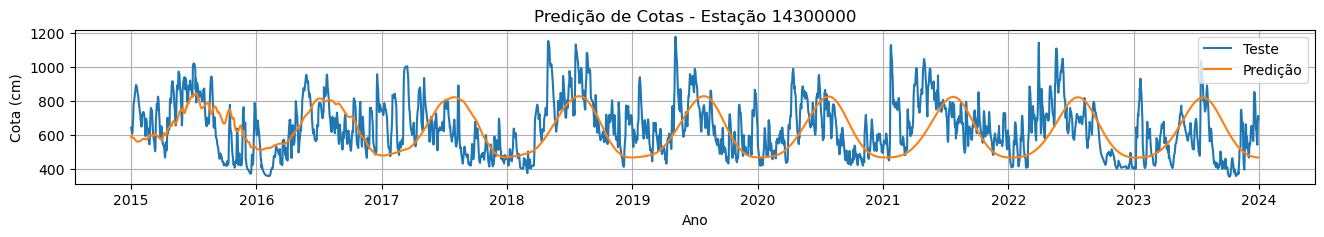

R²: -0.7408, MSE: 43427.4165, RMSE: 208.3925, MAE: 147.0894


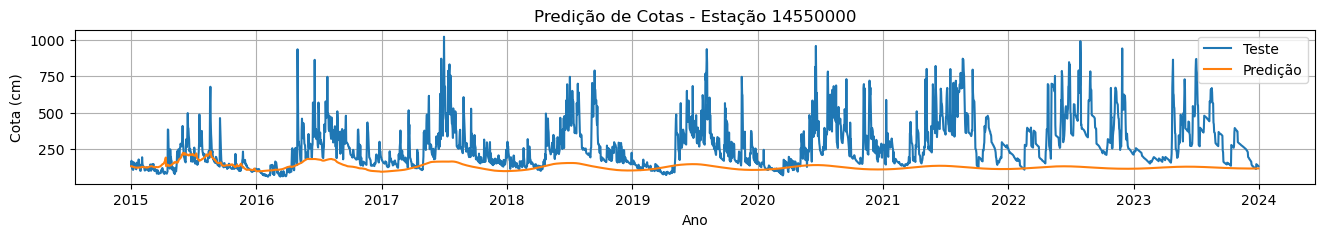

R²: 0.1000, MSE: 19258.0848, RMSE: 138.7735, MAE: 110.7423


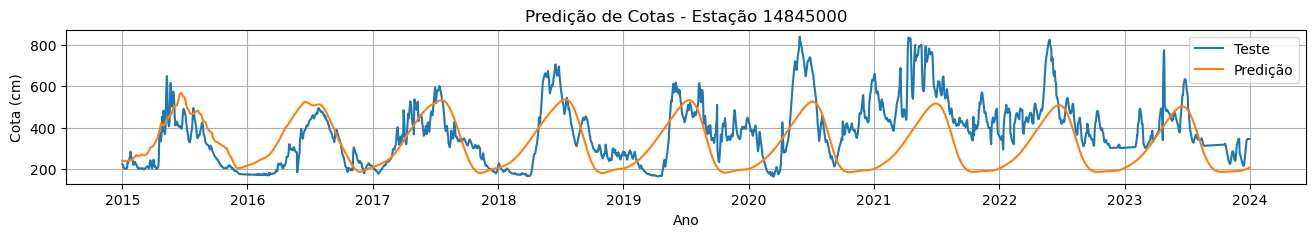

R²: 0.6874, MSE: 55419.1981, RMSE: 235.4128, MAE: 182.8892


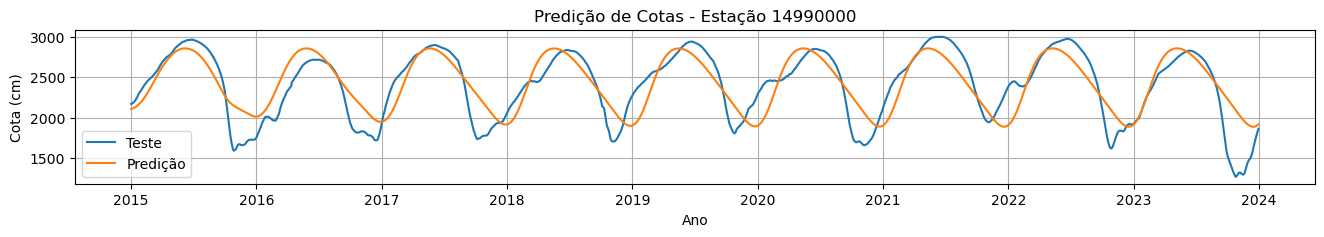

In [12]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(svr, treino[col], teste[col])
    plot_resultado(resultado, teste[col])